In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PBL4/myGaitMixer

/content/drive/MyDrive/PBL4/myGaitMixer


In [ ]:
!pip install ultralytics

Keypoint non-confidence

In [ ]:
# prompt: xử lí các video trong folder

import os
import cv2
import pandas as pd
from ultralytics import YOLO
import numpy as np

# Load mô hình YOLO Pose
model = YOLO("/content/drive/MyDrive/PBL4/yolo11n-pose.pt")

# Đường dẫn đến thư mục chứa video
video_dir = "/content/drive/MyDrive/PBL4/myGaitMixer/video/val"

# Đường dẫn để lưu file CSV
csv_path = "/content/drive/MyDrive/PBL4/myGaitMixer/myData/yolo_val.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)


all_data = []

for filename in os.listdir(video_dir):
    if filename.endswith((".mp4", ".avi", ".mov", ".MOV")) :  # Thêm các đuôi file video khác nếu cần
        video_path = os.path.join(video_dir, filename)
        print(f"Processing video: {filename}")

        # Dự đoán keypoints
        results = model(video_path)

        # Danh sách lưu keypoints của video hiện tại
        data = []
        person_id = int(os.path.splitext(filename)[0].split("_")[-1])

        # Duyệt qua từng frame trong video
        for frame_idx, result in enumerate(results):
            if result.keypoints is not None:
                keypoints = result.keypoints.xyn.cpu().numpy()  # (N, 17, 2)

                # Nếu có confidence scores, thêm vào
                if hasattr(result.keypoints, 'conf') and result.keypoints.conf is not None:
                    confidence = result.keypoints.conf.cpu().numpy()[:, :, np.newaxis]  # (N, 17, 1)
                else:
                    confidence = np.ones((keypoints.shape[0], keypoints.shape[1], 1))  # Nếu không có, mặc định là 1

                # Đảm bảo keypoints có shape (N, 17, 3)
                keypoints = np.concatenate([keypoints, confidence], axis=-1)

            else:
                # Nếu không có keypoints, dùng giá trị -1
                num_keypoints = 17
                keypoints = np.full((1, num_keypoints, 3), -1)  # (1, 17, 3)

            for _, kpt in enumerate(keypoints):
                row = [filename, frame_idx, person_id] + kpt.flatten().tolist()
                data.append(row)


        all_data.extend(data)  # Thêm dữ liệu của video hiện tại vào danh sách tổng

# Tạo DataFrame từ tất cả dữ liệu
keypoint_names = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]

columns = ["image_name", "frame", "person_id"]
for name in keypoint_names:
    columns += [f"{name}_x", f"{name}_y", f"{name}_conf"]

df = pd.DataFrame(all_data, columns=columns)

# Lưu vào file CSV
df.to_csv(csv_path, index=False)

print(f"Keypoints đã được lưu vào {csv_path}")

/content/drive/MyDrive/PBL4/myGaitMixer/myData
Tổng số giá trị 0 trong tất cả các cột keypoint là: 25340


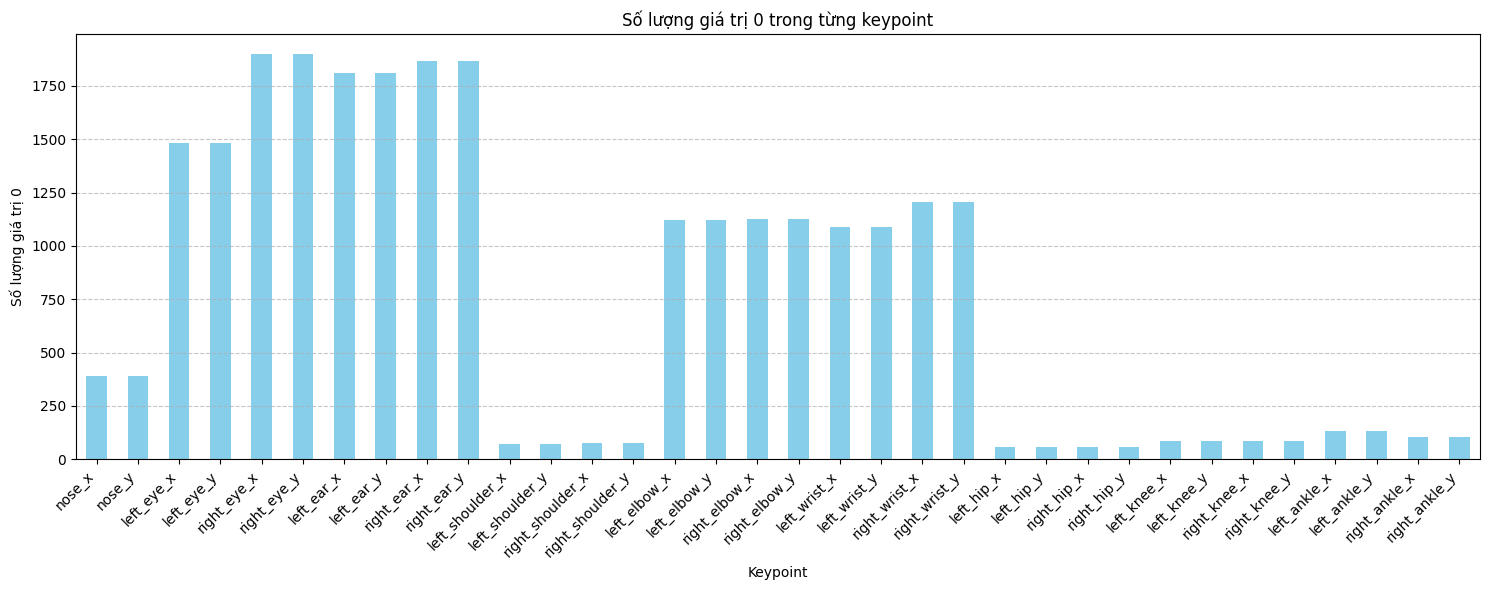

In [ ]:
%cd /content/drive/MyDrive/PBL4/myGaitMixer/myData

# Danh sách tên keypoints
keypoint_names = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]

import pandas as pd
import matplotlib.pyplot as plt

# Đọc file CSV đã đổi tên cột
df = pd.read_csv("keypoints_non_conf.csv")  # đổi tên nếu khác

# Chọn các cột liên quan đến keypoint
keypoint_columns = [col for col in df.columns if '_x' in col or '_y' in col]

# Đếm số lượng giá trị 0 trong mỗi cột
zero_counts = (df[keypoint_columns] == 0).sum()

total_zeros = zero_counts.sum()
print(f"Tổng số giá trị 0 trong tất cả các cột keypoint là: {total_zeros}")

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
zero_counts.plot(kind='bar', color='skyblue')
plt.title("Số lượng giá trị 0 trong từng keypoint")
plt.xlabel("Keypoint")
plt.ylabel("Số lượng giá trị 0")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

